In [11]:
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
from scipy import optimize

In [12]:
def read_dat(filename):
    with open(filename, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter="\t")
        for row in reader:
            last_comma = row[1].rfind(",")
            s = row[1][:last_comma] + row[1][last_comma + 1:]
            j = json.loads(s)
            counts = dict()
            for k, v in j.items():
                counts[int(k)] = v
            yield {"sub": row[0], "counts": counts}

In [13]:
def magnitude(x):
    return int(np.log10(x))

In [14]:
def res_sample(arr, obj, max_size, count):
    if len(arr) < max_size:
        arr.append(obj)
    j = np.random.randint(0, count)
    if j < max_size:
        arr[j] = obj

In [15]:
def count_posts(sub):
    count = 0
    for k, v in sub["counts"].items():
        count += k * v
    return count

In [16]:
def bin_and_sample(d, arr_len = 3):
    bins = dict()
    bin_count = dict()
    for sub in d:
        mag = magnitude(count_posts(sub))
        if mag not in bins:
            bins[mag] = []
            bin_count[mag] = 1
        arr = bins[mag]
        count = bin_count[mag]
        res_sample(arr, sub, arr_len, count)
        bin_count[mag] += 1
    return bins

In [17]:
convert = {0: "ones",
           1: "tens",
           2: "hundreds",
           3: "thousands",
           4: "10 thousands",
           5: "100 thousands",
           6: "millions",
          7: "10 millions",
          8: "100 millions",
          9: "billions"}

In [19]:
dat_file = "../data/subdist.dat"
jsons = read_dat(dat_file)
bins = bin_and_sample(jsons)


{0: [{'sub': 'Science_Tech', 'counts': {1: 1}}, {'sub': 'DiabloUIUC', 'counts': {2: 2}}, {'sub': 'farmjournal', 'counts': {1: 5}}], 1: [{'sub': 'elysewillems', 'counts': {1: 7, 2: 4, 3: 1, 4: 1}}, {'sub': 'Sawnic', 'counts': {1: 1, 3: 2, 7: 1}}, {'sub': 'Moore1994', 'counts': {14: 1}}], 2: [{'sub': 'Undateablelive', 'counts': {1: 28, 18: 1, 2: 7, 3: 3, 4: 1, 44: 1, 5: 2, 6: 3, 7: 1}}, {'sub': 'JFKresearcher', 'counts': {1: 34, 12: 1, 13: 1, 14: 1, 2: 9, 3: 4, 4: 2, 40: 1, 5: 2, 53: 1, 6: 3, 62: 1, 8: 2}}, {'sub': 'GoldenManager_es', 'counts': {1: 60, 10: 6, 11: 2, 13: 2, 14: 1, 16: 1, 19: 1, 2: 5, 3: 2, 4: 4, 5: 3, 52: 1, 6: 2, 9: 3}}], 4: [{'sub': 'insanity', 'counts': {1: 1323, 10: 50, 101: 1, 102: 1, 103: 1, 107: 1, 11: 50, 110: 1, 119: 1, 12: 46, 121: 1, 13: 30, 133: 1, 138: 1, 14: 25, 147: 1, 148: 2, 15: 26, 16: 16, 166: 1, 169: 1, 17: 25, 170: 2, 179: 1, 18: 11, 19: 16, 2: 582, 20: 8, 21: 12, 210: 1, 22: 7, 23: 9, 24: 5, 25: 13, 26: 8, 27: 10, 28: 8, 29: 8, 3: 311, 30: 6, 31: 8, 

In [25]:
print(len(bins))

for k in bins:
    print(len(bins[k]))

9
3
3
3
3
3
3
3
3
1


C:\Users\mcdom\Miniconda3\envs\cs677\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1, top=1
C:\Users\mcdom\Miniconda3\envs\cs677\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  


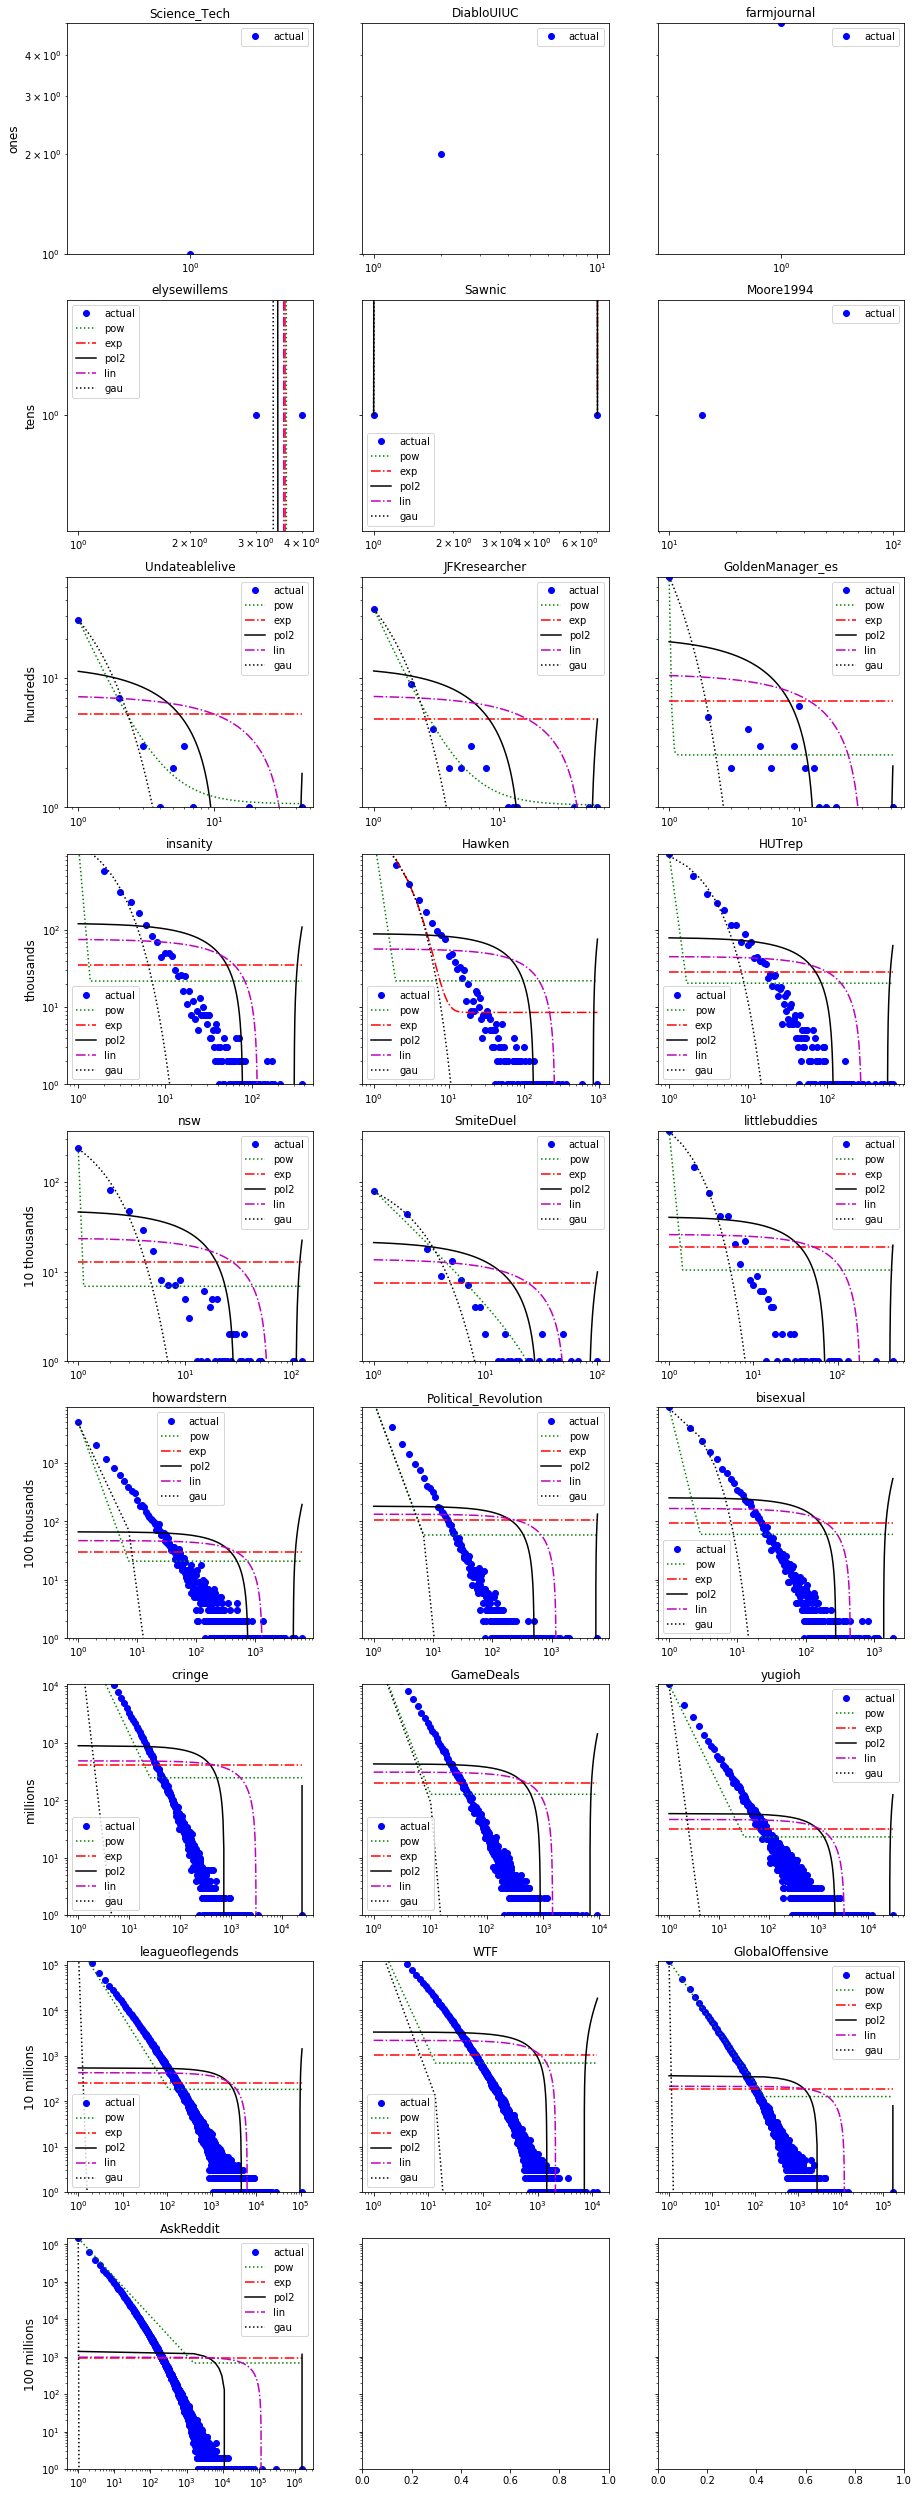

In [32]:
# Fit the first set
fit_funcs = {"pow": (lambda p, x: p[0] + np.power(x,p[1])*p[2]),
            "exp": (lambda p, x: p[0] + np.exp(x*p[1])*p[2]),
            "pol2": (lambda p, x: np.poly1d(p)(x)),
            "lin": (lambda p, x: p[0] + x*p[1]),
             "gau": (lambda p, x: p[0]*np.exp(-(x-p[1])**2/(2.*p[2]**2)))
           } # Target function
def get_err_func(f):
    return lambda p, x, y: f(p, x) - y #Distance to the target function

line_type = {"pow": "g:",
             "exp": "r-.",
             "pol2": "k-",
             "lin": "m-.",
             "gau": "k:",
}
i = 0
j = 0
# Four axes, returned as a 2-d array
f, axarr = plt.subplots(9, 3, sharey='row', figsize=(15,45))
for k, v in bins.items():
    for sub in v:
        if j == 0:
            axarr[i, j].set_ylabel(convert[i], rotation=90, size='large')
        keys = np.fromiter(sub["counts"].keys(), dtype=int)
        values = np.fromiter(sub["counts"].values(), dtype=int)
        axarr[i, j].set_title(sub["sub"])
        axarr[i, j].loglog(keys, values, "bo", label="actual")   
        if keys.shape[0] > 2:
            post_count = np.linspace(keys.min(), keys.max(), 1000)
            for k, v in fit_funcs.items():
                p0 = [np.power(10, i), -1., 1] # Initial guess for the parameters
                p1, success = optimize.leastsq(get_err_func(v), p0, args=(keys, values))
                axarr[i, j].loglog(post_count, v(p1, post_count), line_type[k],  label=k) # Plot of the data and the fit
        axarr[i, j].set_ylim(bottom=1, top=values.max() )
        axarr[i, j].legend()
        j += 1
    i += 1
    j = 0